##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Importing packages

Let's start by importing required packages:

*   os — to read files and directory structure
*   numpy — for some matrix math outside of TensorFlow
*   matplotlib.pyplot — to plot the graph and display images in our training and validation data

In [2]:
import tensorflow as tf

2023-02-27 21:06:16.014326: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Data Loading

To build our image classifier, we begin by downloading the dataset. The dataset we are using is a filtered version of <a href="https://www.kaggle.com/c/dogs-vs-cats/data" target="_blank">Dogs vs. Cats</a> dataset from Kaggle (ultimately, this dataset is provided by Microsoft Research).

In previous Colabs, we've used <a href="https://www.tensorflow.org/datasets" target="_blank">TensorFlow Datasets</a>, which is a very easy and convenient way to use datasets. In this Colab however, we will make use of the class `tf.keras.preprocessing.image.ImageDataGenerator` which will read data from disk. We therefore need to directly download *Dogs vs. Cats* from a URL and unzip it to the Colab filesystem.

In [5]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)

The dataset we have downloaded has following directory structure.

<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>cats_and_dogs_filtered</b>
|__ <b>train</b>
    |______ <b>cats</b>: [cat.0.jpg, cat.1.jpg, cat.2.jpg ....]
    |______ <b>dogs</b>: [dog.0.jpg, dog.1.jpg, dog.2.jpg ...]
|__ <b>validation</b>
    |______ <b>cats</b>: [cat.2000.jpg, cat.2001.jpg, cat.2002.jpg ....]
    |______ <b>dogs</b>: [dog.2000.jpg, dog.2001.jpg, dog.2002.jpg ...]
</pre>

We'll now assign variables with the proper file path for the training and validation sets.

In [6]:
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

In [7]:
train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

### Understanding our data

Let's look at how many cats and dogs images we have in our training and validation directory

In [8]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [9]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


# Setting Model Parameters

For convenience, let us set up variables that will be used later while pre-processing our dataset and training our network.

In [10]:
BATCH_SIZE = 100
IMG_SHAPE  = 150 # Our training data consists of images with width of 150 pixels and height of 150 pixels

After defining our generators for training and validation images, **flow_from_directory** method will load images from the disk and will apply rescaling and will resize them into required dimensions using single line of code.

# Data Augmentation

Overfitting often occurs when we have a small number of training examples. One way to fix this problem is to augment our dataset so that it has sufficient number and variety of training examples. Data augmentation takes the approach of generating more training data from existing training samples, by augmenting the samples through random transformations that yield believable-looking images. The goal is that at training time, your model will never see the exact same picture twice. This exposes the model to more aspects of the data, allowing it to generalize better.

In **tf.keras** we can implement this using the same **ImageDataGenerator** class we used before. We can simply pass different transformations we would want to our dataset as a form of arguments and it will take care of applying it to the dataset during our training process.

To start off, let's define a function that can display an image, so we can see the type of augmentation that has been performed. Then, we'll look at specific augmentations that we'll use during training.

In [11]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

### Flipping the image horizontally

We can begin by randomly applying horizontal flip augmentation to our dataset and seeing how individual images will look after the transformation. This is achieved by passing `horizontal_flip=True` as an argument to the `ImageDataGenerator` class.

In [12]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE,IMG_SHAPE))

Found 2000 images belonging to 2 classes.


To see the transformation in action, let's take one sample image from our training set and repeat it five times. The augmentation will be randomly applied (or not) to each repetition.

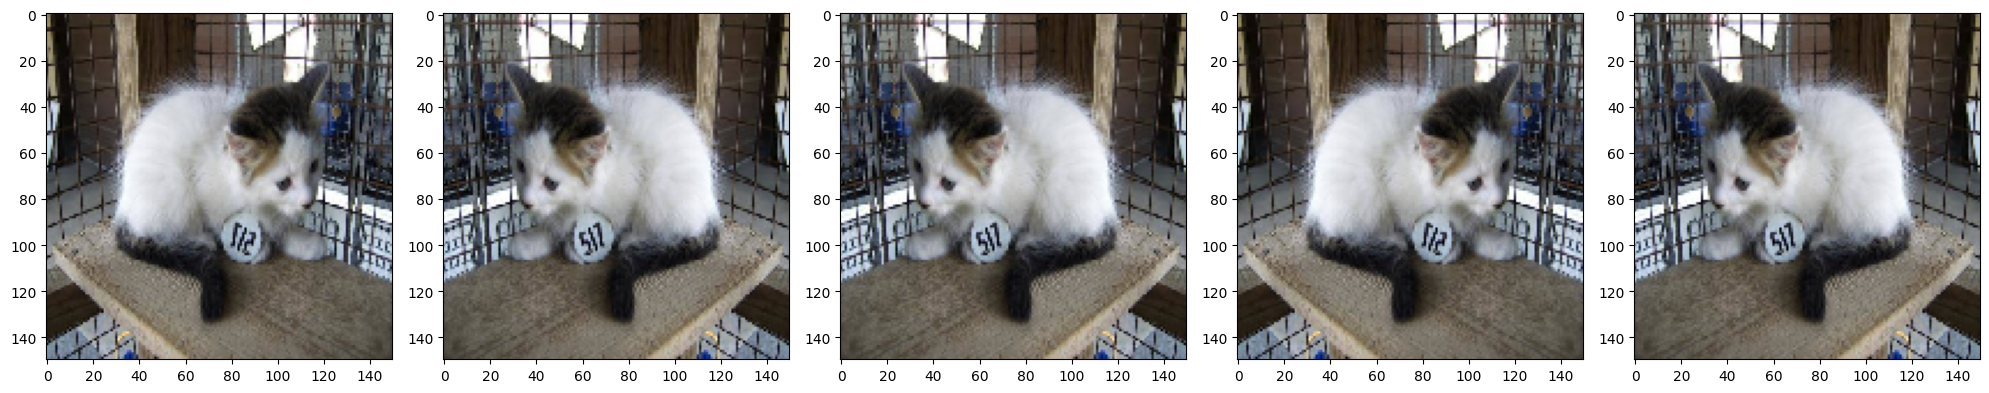

In [13]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Rotating the image

The rotation augmentation will randomly rotate the image up to a specified number of degrees. Here, we'll set it to 45.

In [14]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE, IMG_SHAPE))

Found 2000 images belonging to 2 classes.


To see the transformation in action, let's once again take a sample image from our training set and repeat it. The augmentation will be randomly applied (or not) to each repetition.

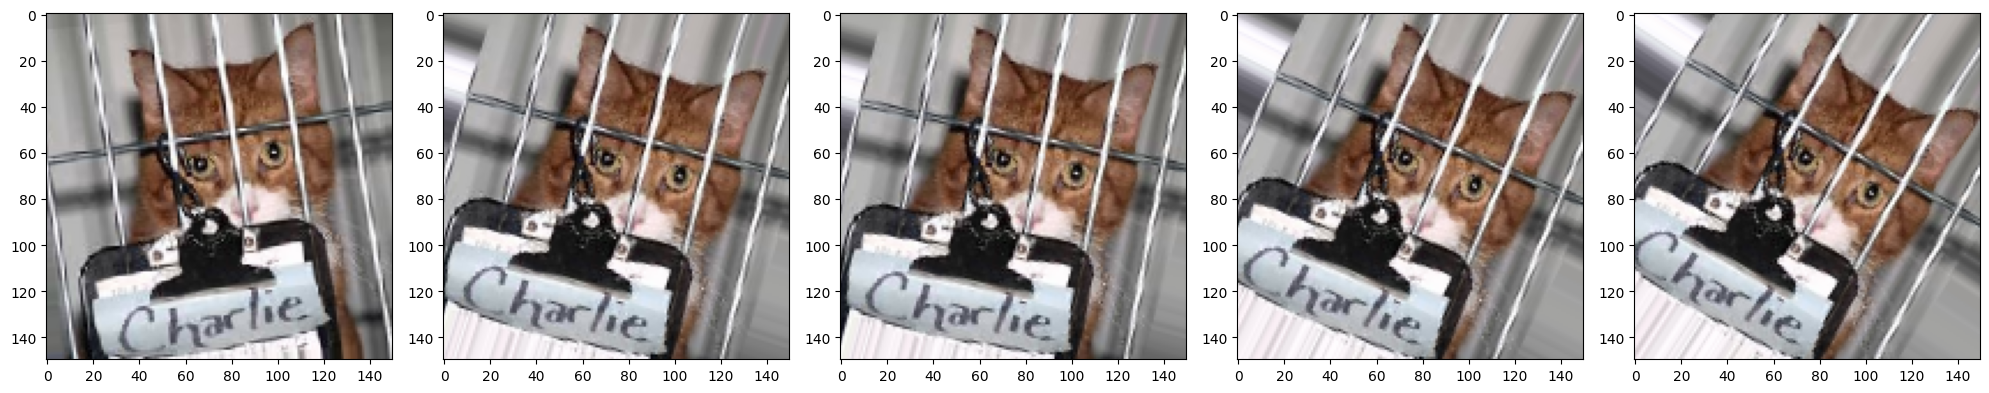

In [15]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Applying Zoom

We can also apply Zoom augmentation to our dataset, zooming images up to 50% randomly.

In [16]:
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE, IMG_SHAPE))


Found 2000 images belonging to 2 classes.


One more time, take a sample image from our training set and repeat it. The augmentation will be randomly applied (or not) to each repetition.

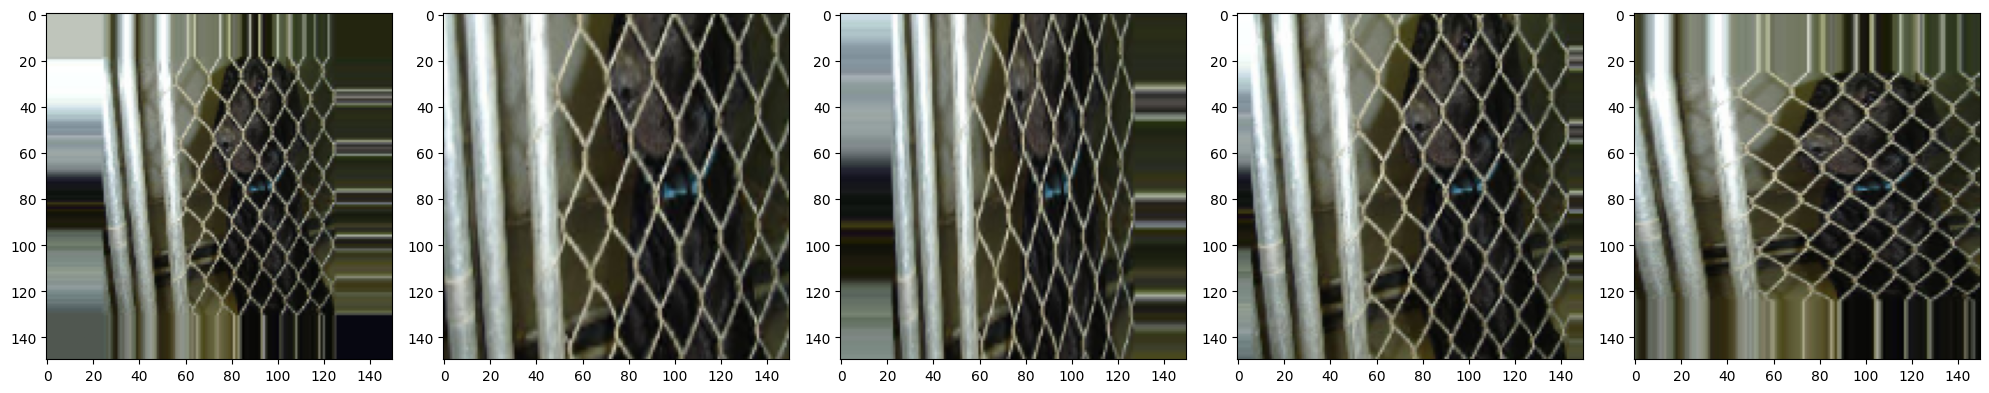

In [17]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Putting it all together

We can apply all these augmentations, and even others, with just one line of code, by passing the augmentations as arguments with proper values.

Here, we have applied rescale, rotation of 45 degrees, width shift, height shift, horizontal flip, and zoom augmentation to our training images.

In [18]:
image_gen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_SHAPE,IMG_SHAPE),
                                                     class_mode='binary')

Found 2000 images belonging to 2 classes.


Let's visualize how a single image would look like five different times, when we pass these augmentations randomly to our dataset. 

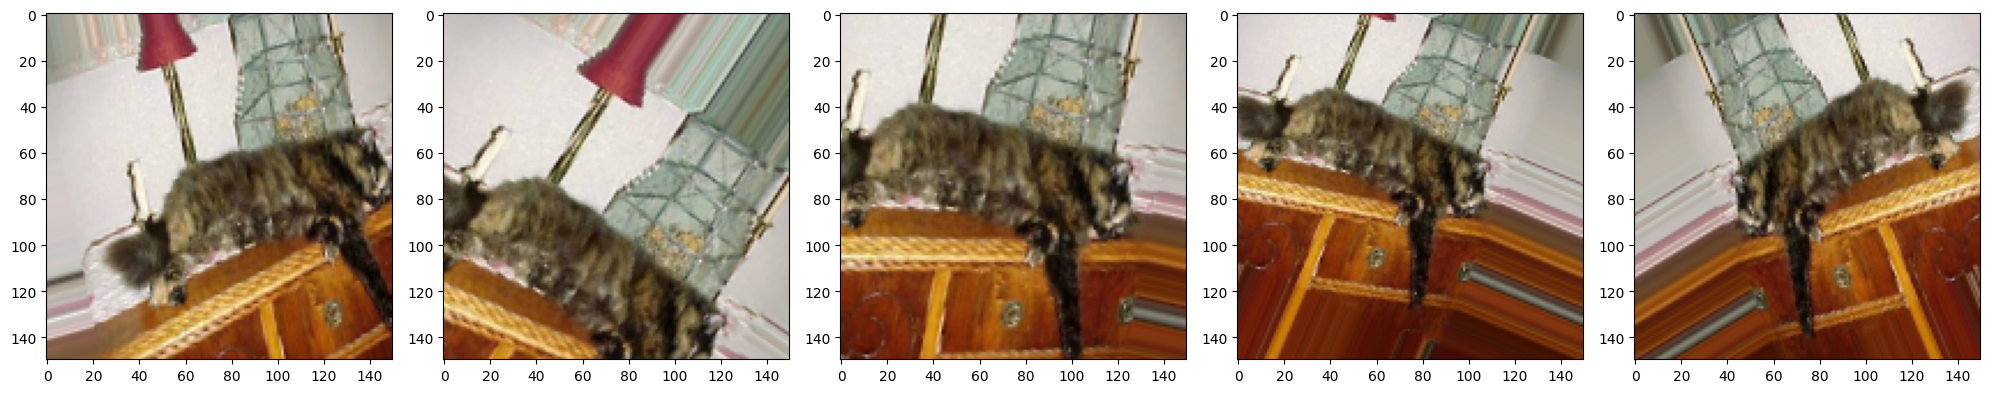

In [19]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Creating Validation Data generator

Generally, we only apply data augmentation to our training examples, since the original images should be representative of what our model needs to manage. So, in this case we are only rescaling our validation images and converting them into batches using ImageDataGenerator.

In [20]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                                 directory=validation_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='binary')

Found 1000 images belonging to 2 classes.


# Model Creation

## Define the model

The model consists of four convolution blocks with a max pool layer in each of them.

Before the final Dense layers, we're also applying a Dropout probability of 0.5. It means that 50% of the values coming into the Dropout layer will be set to zero. This helps to prevent overfitting.

Then we have a fully connected layer with 512 units, with a `relu` activation function. The model will output class probabilities for two classes — dogs and cats — using `softmax`. 

In [21]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2)
])

2023-02-27 21:06:43.313915: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Compiling the model

As usual, we will use the `adam` optimizer. Since we output a softmax categorization, we'll use `sparse_categorical_crossentropy` as the loss function. We would also like to look at training and validation accuracy on each epoch as we train our network, so we are passing in the metrics argument.

In [22]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Customize the Sequential Class with Mechanisms

In [23]:

import sys
sys.path.append("..")

from mechanism.mechanized_sequential import MechanizedSequential
from mechanism.mechanized_sequential import Mechanism
mechanized_model = MechanizedSequential(
    [
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2)
])

## Split the training data into training set and validation set

In [24]:
image_gen = ImageDataGenerator(
      rescale=1./255,
      validation_split = 0.4)



train_generator = image_gen.flow_from_directory(
    batch_size=BATCH_SIZE,
    directory=train_dir,
    shuffle=True,
    target_size=(IMG_SHAPE,IMG_SHAPE),
    class_mode='binary',
    subset='training') # set as training data

validation_generator = image_gen.flow_from_directory(
    batch_size=BATCH_SIZE,
    directory=train_dir,
    shuffle=True,
    target_size=(IMG_SHAPE,IMG_SHAPE),
    class_mode='binary',
    subset='validation')

Found 1200 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [25]:
num_train_examples, num_validation_examples = len(train_generator) * BATCH_SIZE, len(validation_generator) * BATCH_SIZE

### Train the model

In [26]:
epochs=2
history = model.fit_generator(
    train_generator,
    steps_per_epoch=int(np.ceil(num_train_examples / float(BATCH_SIZE))),
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=int(np.ceil(num_validation_examples / float(BATCH_SIZE)))
)

/var/folders/_j/z7zdrth14_s3bcxmp4glxrw40000gp/T/ipykernel_91209/1574167993.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/2
12/12 [==============================] - 25s 2s/step - loss: 0.7116 - accuracy: 0.4908 - val_loss: 0.6918 - val_accuracy: 0.5000
Epoch 2/2
12/12 [==============================] - 30s 3s/step - loss: 0.6916 - accuracy: 0.5233 - val_loss: 0.6880 - val_accuracy: 0.5000


## Choose mechanism and compile the mechanized model

In [27]:
mechanized_model.choose_mech(Mechanism.GAUSSIAN)
mechanized_model.set_mechanism_para(sigma = 0.1)

mechanized_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'],
              run_eagerly = True)

### Train the mechanized model

In [28]:
epochs=2
gaussian_history = mechanized_model.fit_generator(
    train_generator,
    steps_per_epoch=int(np.ceil(num_train_examples / float(BATCH_SIZE))),
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=int(np.ceil(num_validation_examples / float(BATCH_SIZE)))
)

/var/folders/_j/z7zdrth14_s3bcxmp4glxrw40000gp/T/ipykernel_91209/3088519915.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  gaussian_history = mechanized_model.fit_generator(


Epoch 1/2
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
 1/12 [=>............................] - ETA: 29s - loss: 0.7003 - accuracy: 0.5500In Gaussian Mechanism
Create Gaussian noise when accessing the training data
 2/12 [====>.........................] - ETA: 20s - loss: 0.7835 - accuracy: 0.5150In Gaussian Mechanism
Create Gaussian noise when accessing the training data
 3/12 [======>.......................] - ETA: 19s - loss: 0.8079 - accuracy: 0.5400In Gaussian Mechanism
Create Gaussian noise when accessing the training data
 4/12 [=========>....................] - ETA: 17s - loss: 0.7853 - accuracy: 0.5275In Gaussian Mechanism
Create Gaussian noise when accessing the training data
 5/12 [===========>..................] - ETA: 15s - loss: 0.7671 - accuracy: 0.5160In Gaussian Mechanism
Create Gaussian noise when accessing the training data
 6/12 [==============>...............] - ETA: 13s - loss: 0.7551 - accuracy: 0.5133In Gaussian Mechanism
Create G

In [29]:
mechanized_model.choose_mech(Mechanism.THRESHOLD)
mechanized_model.set_mechanism_para(sigma = 0.1, hold_frac = 0.4, threshold = 0.5)

mechanized_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'],
              run_eagerly = True)


threshold_history = mechanized_model.fit_generator(
    train_generator,
    steps_per_epoch=int(np.ceil(num_train_examples / float(BATCH_SIZE))),
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=int(np.ceil(num_validation_examples / float(BATCH_SIZE)))
)

/var/folders/_j/z7zdrth14_s3bcxmp4glxrw40000gp/T/ipykernel_91209/3343357028.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  threshold_history = mechanized_model.fit_generator(


Epoch 1/2
In Threshold out Mechanism
0.0018317478
 1/12 [=>............................] - ETA: 20s - loss: 0.6889 - accuracy: 0.7000In Threshold out Mechanism
0.0101870205
 2/12 [====>.........................] - ETA: 15s - loss: 0.6892 - accuracy: 0.6083In Threshold out Mechanism
0.007660199
 3/12 [======>.......................] - ETA: 13s - loss: 0.6889 - accuracy: 0.5722In Threshold out Mechanism
0.013777083
 4/12 [=========>....................] - ETA: 12s - loss: 0.6877 - accuracy: 0.5625In Threshold out Mechanism
0.0039046132
 5/12 [===========>..................] - ETA: 10s - loss: 0.6877 - accuracy: 0.5700In Threshold out Mechanism
0.015579984
 6/12 [==============>...............] - ETA: 9s - loss: 0.6909 - accuracy: 0.5528 In Threshold out Mechanism
0.011982365
 7/12 [================>.............] - ETA: 7s - loss: 0.6874 - accuracy: 0.5667In Threshold out Mechanism
0.0062846458
 8/12 [===================>..........] - ETA: 6s - loss: 0.6873 - accuracy: 0.5625In Threshold

### Visualizing results of the training

In [30]:
def visualization(history, mech="baseline"):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)
    print(epochs_range)

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label= ('Training Accuracy-'+ mech))
    plt.plot(epochs_range, val_acc, label=('Validation Accuracy-'+ mech))
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss-'+ mech)
    plt.plot(epochs_range, val_loss, label='Validation Loss-'+ mech)
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    

range(0, 2)
range(0, 2)
range(0, 2)


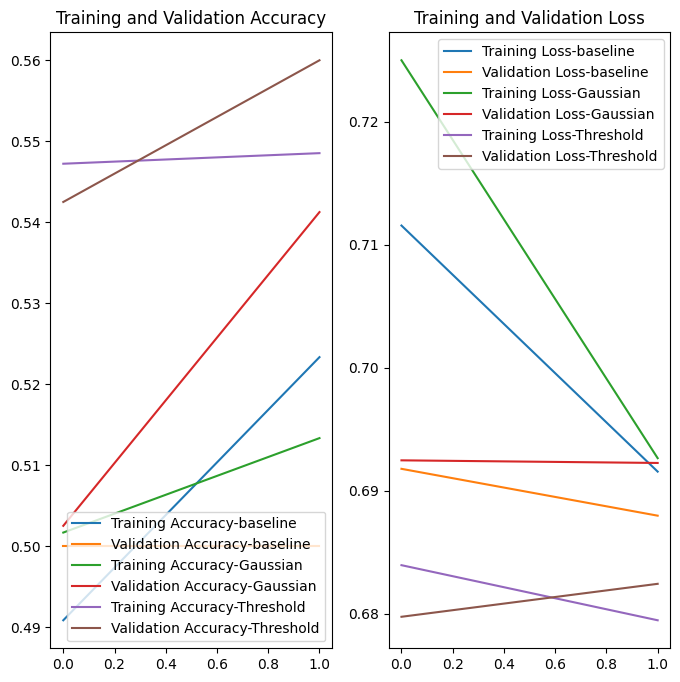

In [31]:
plt.figure(figsize=(8, 8))
visualization(history)
visualization(gaussian_history, "Gaussian")
visualization(threshold_history, "Threshold")
plt.show()


## Evaluate the generalization error

In [34]:
image_gen_test = ImageDataGenerator(rescale=1./255)
test_data_gen = image_gen_test.flow_from_directory(batch_size=BATCH_SIZE,
                                                 directory = validation_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='binary')

num_test_examples = len(test_data_gen) * BATCH_SIZE

Found 1000 images belonging to 2 classes.


In [36]:
import math
test_loss, test_accuracy = model.evaluate(test_data_gen, steps=math.ceil(num_test_examples/BATCH_SIZE))
print('Accuracy on test dataset:', test_accuracy)

10/10 [==============================] - 4s 423ms/step - loss: 0.6876 - accuracy: 0.5000
Accuracy on test dataset: 0.5


### Predict on the Testing Data Set

In [37]:
mechanized_model.choose_mech(None)
test_loss, test_accuracy = mechanized_model.evaluate(test_data_gen, steps=math.ceil(num_test_examples/BATCH_SIZE))
print('Accuracy on test dataset:', test_accuracy)

10/10 [==============================] - 7s 672ms/step - loss: 0.6774 - accuracy: 0.5690
Accuracy on test dataset: 0.5690000057220459
